In [1]:
# V.6_12- добавил приpнак city 
# use all features we have
# добавил анализ тональности текста nltk
# добавил анализ тональности текста nltk jn negative_review

import pandas as pd
import numpy as np 
from scipy import stats
import seaborn as sns
import matplotlib as plt
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


## 1.Считываем данные

In [2]:
hotels = pd.read_csv('hotels.csv')

### Проверка на задублированный данные

In [3]:
hotels.duplicated().sum()

307

### Избавляемся от дублей

In [4]:
hotels = hotels.drop_duplicates()

### Проверка на пропущенные значения

In [5]:
mask_lat = hotels['lat'].isnull()
mask_lng = hotels['lng'].isnull()
hotels[mask_lat | mask_lng]['hotel_address'].shape

(2448,)

In [6]:
# Заполним недостающие значения простым способом...
hotels['lat'] = hotels['lat'].fillna(0)
hotels['lng'] = hotels['lat'].fillna(0)

## 2.Создаем новые признаки

### Cоздадим признак 'city' гостиницы

In [7]:
# создадим признак 'country' гостиницы при помощи функции
def city_finder(arg):
    temp = arg.split(' ')[::-1][1]
    if temp =='United':
        return arg.split(' ')[::-1][4]
    else:
        return temp

hotels['city'] = hotels['hotel_address'].apply(city_finder)

### Выделим признак Времени Года - 'season'

In [8]:
# определим месяц отзыва
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
hotels['month'] = hotels['review_date'].dt.month

In [9]:
def f_season(arg):
    if arg in [12,1,2]:
            return 1
    elif arg in [3,4,5]:
            return 2
    elif arg in [6,7,8]:
            return 3
    elif arg in [9,10,11]:
        return 4
    
hotels['season'] = hotels['month'].apply(f_season)

### Преобразуем 'days since review' в числовое значение

In [10]:
import re
regex1='^\d{1,3}\s'
hotels['days_since_review'] = hotels['days_since_review'].str.findall(regex1).str.get(0).astype('int')

### Cоздаем признак 'nights_stayed'

In [11]:
regex='\s\d{1,2}\s'
hotels['nights_stayed'] = hotels['tags'].str.findall(regex).str.get(0)
hotels['nights_stayed'] = hotels['nights_stayed'].fillna(0)
hotels['nights_stayed'] = hotels['nights_stayed'].astype('int')

### Сoздадим новый признак - Sum of Tags Frequesncy - 'Sum_Tags_freq'


In [12]:
# создадим словарь частотности каждого тега
tags_dict={}

for elem in hotels['tags']:
    elem = elem.split(', ')
    for i in elem:
        a = i.replace(']','')  # очищаем нашу строку
        a = a.replace('[','')
        a = a.replace("'",'')
        if a not in tags_dict.keys():
            tags_dict[a]=1
        else:
            tags_dict[a]+=1


In [13]:
# напищем функцию, которая считает сумму баллов частотности всех тегов в одном отзыве
 
def tags_freq(arg):
    arg = arg.split(', ')
    for elem in arg:
        tlst=[]
        for i in arg:
            a = i.replace(']','')
            a = a.replace('[','')
            a = a.replace("'",'')
            tlst.append(tags_dict[a])
    return(sum(tlst))

hotels['sum_tags_freq'] = hotels['tags'].apply(tags_freq)

### Попробуем проанализировать тональность текста при помощи nltk

In [14]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


# nltk.downloader.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()

def f_sent(arg):
    result = sent_analyzer.polarity_scores(arg)
    return result['compound']

hotels['sent_grade'] = hotels['positive_review'].apply(f_sent)

# добавим такой признак по negative_review
hotels['sent_grade_n'] = hotels['negative_review'].apply(f_sent)

## 3.Преобразование признаков

In [15]:
# Прокодируем поле 'country' бинарным кодированием...
import category_encoders as ce # импорт для работы с кодировщиком

bin_encoder = ce.BinaryEncoder(cols=['city']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['city'])
hotels = pd.concat([hotels, type_bin], axis=1)


In [16]:
# Прокодируем поле 'reviewer_nationality' бинарным кодированием...

bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin], axis=1)

In [17]:
# убираем ненужные колонки
columns_to_drop = ['hotel_address','review_date', 'hotel_name', 'negative_review','positive_review','tags','city','reviewer_nationality',]
hotels.drop(columns_to_drop,axis=1,inplace=True)

### Нормализуем все признаки в отдельном дата фрейме... 

In [18]:
# Применим MinMAxScaler (так как онпредставляет данные в положительном диапазоне...)
from sklearn import preprocessing

col_names = list(hotels.columns)

# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.MinMaxScaler()

# кодируем исходный датасет
hotels_r = r_scaler.fit_transform(hotels)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
hotels_r = pd.DataFrame(hotels_r, columns=col_names)



## 4.Отбор признаков

### Оценка значимости каждого признака

In [19]:
# Для начала разделим признаки по типу, перечислим их
# непрерывные признаки
num_cols = [
    'additional_number_of_scoring',
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'total_number_of_reviews_reviewer_has_given'
    ]

# категориальные признаки
cat_cols = ['average_score',
            'days_since_review',
            'lat',
            'lng',
            'month',
            'season',
            'nights_stayed',
            'sum_tags_freq',
            'sent_grade',
            'sent_grade_n',
            'city_0',
            'city_1',
            'city_2',
            'reviewer_nationality_0',
            'reviewer_nationality_1',
            'reviewer_nationality_2',
            'reviewer_nationality_3',
            'reviewer_nationality_4',
            'reviewer_nationality_5',
            'reviewer_nationality_6',
            'reviewer_nationality_7']

In [20]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_r.drop(['reviewer_score'], axis = 1)  
y = hotels_r['reviewer_score'] 

<Axes: >

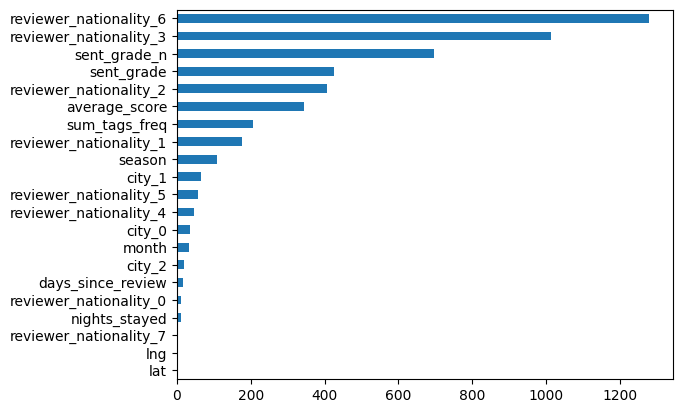

In [21]:
# Проверим на знаимость Категориальные признаки...

y=y.astype('int')
...
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Убираем 4 самых слабых признака...

In [22]:
hotels = hotels.drop(['reviewer_nationality_7',
                          'lng',
                          'nights_stayed',
                          'reviewer_nationality_0',
                          ], axis=1)

<Axes: >

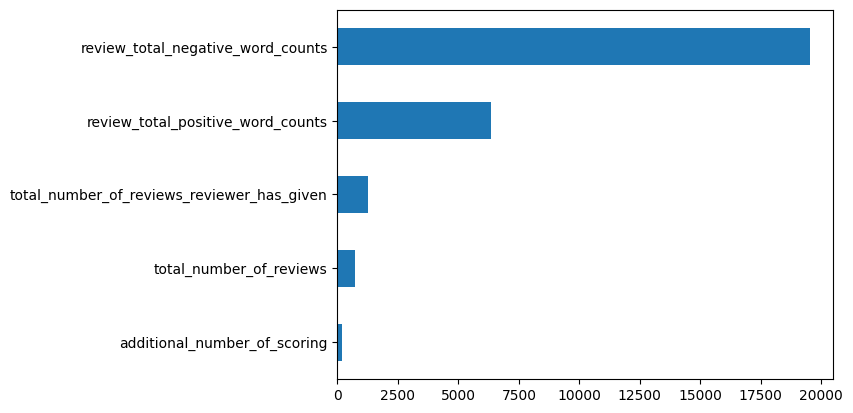

In [23]:
# Проверим на знаимость Числовые признаки...

from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Убираем 1 самый слабый признак

In [24]:
hotels = hotels.drop(['additional_number_of_scoring'], axis=1)

## Тестирование модели

In [25]:
# Разбиваем тестируемый (оригинальный) датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [26]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [27]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [28]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [29]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1256951981858791


Небольшой бонус:


In [30]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*10

MAPE(y_test, y_pred)

1.256951981858791